# Coding

In [3]:
import numpy as np
import _pickle as cPickle
import os
import gzip

In [4]:
# Data Loading
# We first define a function for downloading and loading MNIST.
# **WARNING**: Executing it will obviously use up some space on your machine ;). 

def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
#         print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

#     print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
#     print('... done loading data')
    return rval

## Layers and Helper functions

We completed the provided code stubs for:

- gradients for the sigmoid, tanh, relu, and linear (none) activation functions

- weight initialisation (using a mean of zero, and the stdev parameter passed to the function)

- forward propagation, which yields $h(\mathbf{XW+b})$ given input $\mathbf{X}$

- backward propagation, which calculates $\frac{\partial L}{\partial \mathbf{X}}$ per the above

- loss ($L$) and the `input_gradient` functions ($\frac{\partial L}{\partial\hat{y}}$) for the linear and softmax output layers

In the `FullyConnectedLayer` class, we added:

- implementation of optional **dropout** with a user-specified dropout rate. This zeroes out fraction $p$ of outputs at train time, and scales all output down by $\frac{1}{1-p}$ at test time. The purpose of dropout is to force the network _not_ to rely on any particular weight, theoretically making it more robust.

- implementation of optional **L1 and/or L2 regularisation**. The respective norms on the weight matrix are calculated by new functions in this layer, and later passed on to the loss function. The additional L1 and L2 updates to the weight matrix are calculated in the `bprop` function.

- variables to store the first and second moment of the gradient, which gets used later by the momentum, RMSProp and Adam optimisers

In [5]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    """differential of the sigmoid function"""
    sig = sigmoid(x)
    return sig * (1 - sig) # ADR

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    """differential of the hyperbolic tangent function"""
    return 1 - (tanh(x) ** 2) # ADR

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    """differential of the ReLU function"""
    return np.where(x < 0, 0, 1) # ADR

# ADR - added. Cleaner than 'none' as activation function
def linear(x):
    return x

def linear_d(x):
    return np.ones_like(x)

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def cross_entropy(y, y_pred):
    """cross entropy: natural loss function for softmax"""
    # y should be a one-hot vector; y_pred can be real-valued
    # both are [nxk] matrices
    
    # to make the loss numerically stable 
    # you should add an epsilon in the log ;)
    eps = 1e-10
    
    return -np.sum(y * np.log(y_pred + eps), axis=1)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

In [6]:
# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        elif tname == 'linear':
            self.act = linear
            self.act_d = linear_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        # hadamard product 
        return output_grad * self.act_d(self.last_input)

# define a base class for layers
class Layer(object):
    
    def fprop(self, input, train_time=False):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input, train_time=False):
        return input
    
    def bprop(self, output_grad):
        return output_grad

In [7]:
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """

    # n:= batch_size
    # i:= dimension of input data (self.input_shape[1])
    # j:= dimension of this layer's data (num_units)
    # k:= dimension of next layer's data

    def __init__(self,
                 input_layer, #[nxi]
                 num_units,
                 init_stddev,
                 activation_fun=Activation('relu'),
                 dropout=0.0,
                 l1_penalty=0.0,
                 l2_penalty=0.0):
        
        self.num_units = num_units
        self.init_stddev = init_stddev

        # ADR - cleaner than checking for 'None' all the time
        if activation_fun is None:
            activation_fun = Activation('linear')

        self.activation_fun = activation_fun
        self.input_shape = input_layer.output_size()

        # implemented: dropout
        assert 0.0 <= dropout < 1.0, "Dropout must be in the range [0, 1)"
        self.dropout = dropout
        
        # implemented: l1 and l2
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

        # we split this off so that it can be called independently
        self.reset_weights()

    # added
    def reset_weights(self):
        # this is the weight matrix it should have shape: (num_units_prev, num_units) = (i, j)
        self.W = np.random.normal(scale=self.init_stddev, size=(self.input_shape[1],
                                        self.num_units))  # ADR

        # and this is the bias vector of shape: (num_units)
        self.b = np.random.normal(scale=self.init_stddev, size=(self.num_units))  # ADR

        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None

        # used for RMSProp and Adam, optionally
        self.dW_m1 = np.zeros_like(self.W)
        self.dW_m2 = np.zeros_like(self.W)
        self.db_m1 = np.zeros_like(self.b)
        self.db_m2 = np.zeros_like(self.b)

    def output_size(self):
        return (self.input_shape[0], self.num_units)

    def fprop(self, input, train_time=False):
        # you again want to cache the last_input for the bprop
        self.last_input = input

        # implementation below!

        linear = (input @ self.W) + self.b
        # [nxj] = [nxi] @ [ixj] + [j]

        activated = self.activation_fun.fprop(linear)

        if self.dropout > 0:
            if train_time:
                self.dropout_filter = np.random.binomial(
                    1, (1 - self.dropout), size=activated.shape)
#                 self.dropout_filter = np.random.binomial(
#                     1, (1 - self.dropout), size=(1, activated.shape[1]))

                # save this for when we do backprop later
                activated *= self.dropout_filter

            else:
                self.dropout_filter = np.ones(shape=activated.shape)
                #scale activations down
                activated *= (1 - self.dropout)

        return activated
        # element-wise operation: still [nxj]

    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # output_grad = dL/dZ [nxj]

        n = output_grad.shape[0]

        # dL/dA = dL/dZ * act'(A)
        grad_A = self.activation_fun.bprop(output_grad)
        
        if self.dropout > 0:
            grad_A *= self.dropout_filter
        
        # dL/dW[ixj] = XT[ixn] @ dL/dA[nxj]
        self.dW = self.last_input.T @ grad_A

        if self.l1_penalty != 0.0:
            # elementwise minimum -- this may not be necessary given that a learning rate will be applied
            # to the gradient later, but in any case it will ensure that no weight is pushed *below* zero.
            capped_penalty = np.minimum(self.l1_penalty, np.abs(self.W))
#             self.dW += capped_penalty * np.sign(self.W)
            self.dW += self.l1_penalty * np.sign(self.W)

        if self.l2_penalty != 0.0:
            self.dW += self.W * self.l2_penalty
        
        # dL/db[1xj] = sum_n(dL/dA[nxj])
        self.db = np.sum(grad_A, axis=0)

        # the gradient wrt. the input should be calculated here

        #grad_input = np.zeros_like(self.last_input)
        #this is the previous (input) layer's dL/dZ gradient
        #dL/dZprev[nxi] = dL/dA[nxj] @ dL/dW.T[jxi]
        grad_input = grad_A @ self.W.T

        return grad_input
    
    def params(self):
        return self.W, self.b

    def set_params(self, W, b):
        self.W, self.b = W, b
    
    def grad_params(self):
        return self.dW, self.db

    # adr
    def m1_grad_params(self):
        return self.dW_m1, self.db_m1

    def set_m1_grad_params(self, dW_m1, db_m1):
        self.dW_m1, self.db_m1 = dW_m1, db_m1

    def m2_grad_params(self):
        return self.dW_m2, self.db_m2
    
    def set_m2_grad_params(self, dW_m2, db_m2):
        self.dW_m2, self.db_m2 = dW_m2, db_m2

    def weight_loss(self):
        weight_loss = 0.0
        
        if self.l1_penalty != 0.0:
            weight_loss += (np.sum(np.abs(self.W)) * self.l1_penalty)

        if self.l2_penalty != 0.0:
            weight_loss += (np.sum(self.W ** 2) * self.l2_penalty) / 2
            
        return weight_loss

In [8]:
# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input, train_time=False):
        # no activation
        return linear(input)

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        return (Y_pred - Y) / Y.shape[0] # adr - matches DL slide 29

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1)) # this averages across datapoints (1/n is taken care of)

In [9]:
class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input, train_time=False):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # dL/dZ = dL/dY * dY/dZ
        return (Y_pred - Y) / Y.shape[0]

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        out = Y_pred
        
        loss = cross_entropy(Y, Y_pred)
        return np.mean(loss)
        

## Neural Network class

We next completed the `NeuralNetwork` stub:

- the `predict` function cycles forward, calling `fprop` on every layer

- the `backpropagate` function cycles backward, calling `bprop` on every layer

- the `sgd_epoch` and `gd_epoch` training functions are completed. Note that `gd_epoch` simply calls `sgd_epoch` with a batch size equal to the total training set.

We have implemented **additional optimisers** inside the `sgd_epoch` function, using the algorithms presented in Goodfellow & Bengio's _Deep Learning Book_: Gradient descent with **Momentum**; **RMSProp**; and **Adam**. The required moments of the gradient are stored as variables inside each layer and updated at each timestep.

Note: the code for these optimisers is made somewhat clunky by cycling through a list of parameters, which in fact contains only $\mathbf{w}$ and $b$. Using augmented input data and a single weight parameter would have made life easier here!

In [10]:
class NeuralNetwork:
    """ Our Neural Network container class.
    """

    def __init__(self, layers):
        self.layers = layers
        self.timestep = 0

    def _loss(self, X, Y):
        Y_pred = self.predict(X)

        # adr - added weights penalty
        loss = self.layers[-1].loss(Y, Y_pred)

        for layer in self.layers:
            if isinstance(layer, Parameterized):
                loss += layer.weight_loss()

        return loss

    def reset_weights():
        for layer in self.layers:
            layer.reset_weights()

    def predict(self, X, train_time=False):
        """ Calculate an output Y for the given input X. """
        # adr
        Z = X

        for layer in self.layers:
            Z = layer.fprop(Z, train_time)

        Y_pred = Z
        return Y_pred

    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        # note, this final layer has no weights -- it merely applies a final output function (e.g. softmax) to z_t
        next_grad = self.layers[-1].input_grad(Y, Y_pred)

        #from second last layer down to 'upto', in reverse order
        for layer in self.layers[-2:(None if upto == 0 else upto - 1):-1]:
            next_grad = layer.bprop(next_grad)

        return next_grad

    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))

        #adr added
        if len(Y.shape) > 1:
            Y = unhot(Y)

        error = Y_pred != Y
        return np.mean(error)

    def sgd_epoch(self,
                  X,
                  Y,
                  learning_rate,
                  batch_size,
                  optimiser,
                  m1_decay=None,
                  m2_decay=None):
        """
        Stochastic gradient descent
        """

        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        epsilon = 1e-8

        for b in range(n_batches):
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)

            X_batch = X[b * batch_size:(b + 1) * batch_size, ...]
            Y_batch = Y[b * batch_size:(b + 1) * batch_size, ...]

            Y_pred = self.predict(X_batch, train_time=True)
            X_grad = self.backpropagate(Y_batch, Y_pred)

            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place

            # how???

            for l, layer in enumerate(self.layers):
                if isinstance(layer, Parameterized):

                    if optimiser == "vanilla":
                        layer.set_params(*[
                            param + (-1 * learning_rate * grad)
                            for param, grad in zip(layer.params(),
                                                   layer.grad_params())
                        ])

                    if optimiser in ("momentum", "adam"):
                        layer.set_m1_grad_params(
                            *[(m1 * m1_decay) + (1 - m1_decay) * grad
                              for grad, m1 in zip(layer.grad_params(),
                                                  layer.m1_grad_params())])

                    if optimiser in ("rmsprop", "adam"):
                        layer.set_m2_grad_params(
                            *[(m2 * m2_decay) + (1 - m2_decay) * (grad**2)
                              for grad, m2 in zip(layer.grad_params(),
                                                  layer.m2_grad_params())])

                    if optimiser == "momentum":
                        layer.set_params(*[
                            param + (-1 * learning_rate * m1)
                            for param, m1 in zip(layer.params(),
                                                 layer.m1_grad_params())
                        ])

                    if optimiser == "rmsprop":
                        layer.set_params(*[
                            param + (-1 * learning_rate *
                                     (grad / (np.sqrt(m2) + epsilon)))
                            for param, grad, m2 in zip(layer.params(
                            ), layer.grad_params(), layer.m2_grad_params())
                        ])

                    if optimiser == "adam":
                        self.timestep += 1
                        layer.set_params(*[
                            param + (-1 * learning_rate * (
                                (m1 / (1 - (m1_decay**self.timestep))) /
                                (np.sqrt(
                                    (m2 /
                                     (1 -
                                      (m2_decay**self.timestep)))) + epsilon)))
                            for param, grad, m1, m2 in zip(
                                layer.params(), layer.grad_params(),
                                layer.m1_grad_params(), layer.m2_grad_params())
                        ])

        pass

    def gd_epoch(self,
                 X,
                 Y,
                 learning_rate,
                 optimiser,
                 m1_decay=None,
                 m2_decay=None):
        # runs sgd with entire dataset as batch!
        # possible todo: run sgd batchwise but delay weight updates to end
        return self.sgd_epoch(X, Y, learning_rate, X.shape[0], optimiser,
                              m1_decay, m2_decay)

    def train(self,
              X,
              Y,
              X_valid,
              Y_valid,
              learning_rate=0.1,
              max_epochs=100,
              batch_size=64,
              descent_type="sgd",
              y_one_hot=True,
              optimiser="vanilla",
              m1_decay=None,
              m2_decay=None):
        """ Train network on the given data. """

        # first make sure we've got all the hypers we'll need for the given optimiser
        if optimiser == "vanilla":
            pass
        elif optimiser == "momentum":
            assert 0 < m1_decay < 1, "try again"
        elif optimiser == "rmsprop":
            assert 0 < m2_decay < 1, "try again"
        elif optimiser == "adam":
            assert 0 < m1_decay < 1, "try again"
            assert 0 < m2_decay < 1, "try again"
        else:
            raise NotImplementedError("Unknown optimiser {}".format(optimiser))

        n_samples = X.shape[0]
        n_batches = n_samples // batch_size

        # added
        train_errors = []
        valid_errors = []

        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")

        for e in range(max_epochs + 1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size,
                               optimiser, m1_decay, m2_decay)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate, optimiser, m1_decay,
                              m2_decay)
            else:
                raise NotImplementedError(
                    "Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            train_error = self.classification_error(X, Y)
            valid_error = self.classification_error(X_valid, Y_valid)

            train_errors.append(train_error)
            valid_errors.append(valid_error)

            print(
                'epoch {:.4f}, loss {:.4f}, train error {:.4f}, validation error {:.4f}'
                .format(e, train_loss, train_error, valid_error))

        return train_errors, valid_errors

    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape

                    # define functions for conveniently swapping
                    # out parameters of this specific layer and
                    # computing loss and gradient with these
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))

                    # To debug you network's gradients use scipys
                    # gradient checking!
                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(
                        output_given_params, grad_given_params, param_init)
                    print('diff scipy {:.2e}'.format(err))
                    assert (err < epsilon)

                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
We've used gradient checking on all activation functions and regularisation approaches.
Everything here worked properly, _except_ dropout. This seems to be because the `check_gradients()` function does not apply the dropout mask that we implemented.

In [11]:
input_shape = (20, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=80,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=20,
                init_stddev=0.1,
                l2_penalty=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=20,
                init_stddev=0.1, 
                l1_penalty=0.1,
                activation_fun=Activation('sigmoid')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('linear'),
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [12]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [146]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff scipy 1.18e-06
diff scipy 4.17e-07
checking gradient for layer 2
diff scipy 1.88e-06
diff scipy 2.16e-07
checking gradient for layer 3
diff scipy 8.92e-07
diff scipy 2.25e-07
checking gradient for layer 4
diff scipy 4.85e-07
diff scipy 8.95e-08


# Training on MNIST / Hyperparameter Search

In [14]:
# Finally we can let our network run on the MNIST dataset!

# First load the data and reshape it.
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

In [57]:
# *Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:
    
# print("X_train shape: {}".format(np.shape(X_train)))
# print("y_train shape: {}".format(np.shape(y_train)))

In [56]:
X_train = X_train.reshape(X_train.shape[0], -1)
# print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
# print("Reshaped X_valid size: {}".format(X_valid.shape))

Given than this network runs on a CPU, it is relatively slow. We are therefore limited in our scope for hyperparameter searching; also, we haven't gotten to this part of the lab yet :)
Still, we tested a number of different combinations of architecture choices:

1. "flat" (equal number of nodes per layer) vs "tapered" (more nodes in the base layers, fewer nodes in the upper layers)

2. Regularising each layer with each combination of L1, L2, dropout, or none of the above.

3. Since we were already working a large number of networks to test, we used the ReLU for all activation functions (except the last layer), since this has shown good results in practice elsewhere.

Each candidate network was trained for 20 epochs. We recorded the final validation error of each candidate network and evaluated them on this basis.

We found that our best results came from:

- a network with tapered (400-200-100-10) layer design. This makes sense: low-level features (e.g. pixel combinations) will require high dimensionality across the input images, whereas high-level features (e.g. loops, strokes) should be relatively low-dimensional. CNNs are therefore often designed this way

- L2 regularisation $(\lambda = 0.01)$ on the last two layers. We want to enforce a prior on the weights (i.e. smallness) to improve the network's generalisation properties. However, adding L2 on the first two layers, and increasing the strength of the weights, led to worse performance on the validation set, probably indicating that our prior was over-constraining the solution.

- dropout of 25% on the third layer

- no L1 regularisation. We had expected a prior enforcing sparsity to work well, in that it would avoid picking up spurious low-level features. But in practice, it didn't.

However, there are many other possible architectures that we found had almost indistinguishable performance, and certainly more that we could have tested but didn't. So our final choice here is somewhat arbitrary, and certainly not optimal. For comparison, compare its results to two minor variations:

- Using no L2 regularisation gives a very slight degradation in performance

- Using L2 regularisation on *all* layers instead of just the last two gives a more noticeable degradation

In [165]:
# result imported from tfpool
results_good = cPickle.load(open('results_good.pkl','rb'))
results_notenough = cPickle.load(open('results_notenough.pkl','rb'))
results_toomuch = cPickle.load(open('results_toomuch.pkl','rb'))

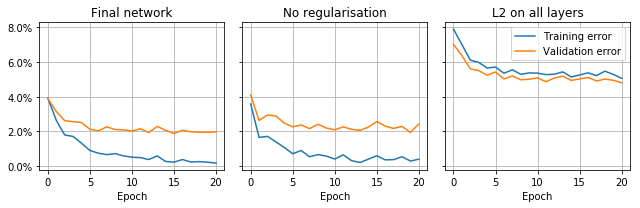

In [163]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9, 3))
# fig.suptitle('Network performance')
fig.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.grid()
ax1.set_title('Final network')
ax1.plot(results_good[0], label='Training error')
ax1.plot(results_good[1], label='Validation error')
ax1.set_xlabel('Epoch')

ax3.set_title('L2 on all layers')
ax3.plot(results_toomuch[0], label='Training error')
ax3.plot(results_toomuch[1], label='Validation error')
ax3.set_xlabel('Epoch')

ax2.set_title('No regularisation')
ax2.plot(results_notenough[0], label='Training error')
ax2.plot(results_notenough[1], label='Validation error')
ax2.set_xlabel('Epoch')
# plt.ylabel = 'Error'
ax3.legend()
ax1.grid()
ax2.grid()
ax3.grid()
fig.tight_layout()
plt.show()

# Final Network

Using our results from the hyperparameter search, we set up the final network (training on full dataset for 50 epochs) and show the results. Our final test error is **1.52%**.

In [17]:
# disabled for notebook speed. Alter the line below to run training.

import time

if 2 + 2 == 4:
    
    ### FINAL NETWORK
    
    np.random.seed(123)
    # Setup a small MLP / Neural Network
    # we can set the first shape to None here to indicate that
    # we will input a variable number inputs to the network
    input_shape = (None, 28 * 28)
    layers = [InputLayer(input_shape)]
    layers.append(
        FullyConnectedLayer(
            layers[-1],
            num_units=400,
            init_stddev=0.1,
            activation_fun=Activation('relu')
        ))
    layers.append(
        FullyConnectedLayer(
            layers[-1],
            num_units=200,
            init_stddev=0.1,
            activation_fun=Activation('relu')))
    layers.append(
        FullyConnectedLayer(
            layers[-1],
            num_units=100,
            init_stddev=0.1,
            dropout=0.25,
            activation_fun=Activation('relu'),
            l2_penalty=0.01))
    layers.append(
        FullyConnectedLayer(
            layers[-1],
            num_units=10,
            init_stddev=0.1,
            l2_penalty=0.01,
            # last layer has no nonlinearity
            # (softmax will be applied in the output layer)
            activation_fun=None))
    layers.append(SoftmaxOutput(layers[-1]))

    nn = NeuralNetwork(layers)
    # Train neural network
    t0 = time.time()
    train_errors, valid_errors = nn.train(
        np.vstack([X_train, X_valid]), # altered for final run. 
        np.hstack([y_train, y_valid]), # Of course we intially trained only on X_train!
        X_valid,
        y_valid,
        learning_rate=0.001,
        max_epochs=50,
        batch_size=64,
        y_one_hot=True,
        m1_decay=0.9,
        m2_decay=0.99,
        optimiser='adam')
    t1 = time.time()
    print('Duration: {:.1f}s'.format(t1 - t0))

    cPickle.dump(nn, open('final_net.pkl', 'wb'))

In [166]:
# result imported from tfpool

final_net = cPickle.load(open('final_net.pkl','rb'))

In [167]:
X_test, y_test = Dtest
X_test = X_test.reshape(X_test.shape[0], -1)

y_test_pred = unhot(final_net.predict(X_test))

errors = (y_test != y_test_pred)
errors_by_no = np.array([[i, errors[y_test == i].mean()] for i in range(0, 10)])

In [169]:
print("Training error (hyperparam search phase) {:.3%}".format(results_good[0][-1]))
print("Validation error (hyperparam search phase) {:.3%}".format(results_good[1][-1]))
print("\nTest error (after training on T+V) {:.3%}".format(errors.mean()))

Training error (hyperparam search phase) 0.168%
Validation error (hyperparam search phase) 1.970%

Test error (after training on T+V) 1.520%


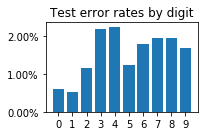

In [170]:
plt.figure(figsize=(3,2))
plt.bar(*errors_by_no.T)
plt.title('Test error rates by digit')
plt.xticks(np.arange(10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()
plt.show()

We can see that some inputs (3, 4) are much harder to accurately classify than others (0, 1). There are many other analyses we could do, but we're already running over the requested page count. So, finally, let's look at a sample of the test inputs that our network misclassified, some of which look pretty unusual:

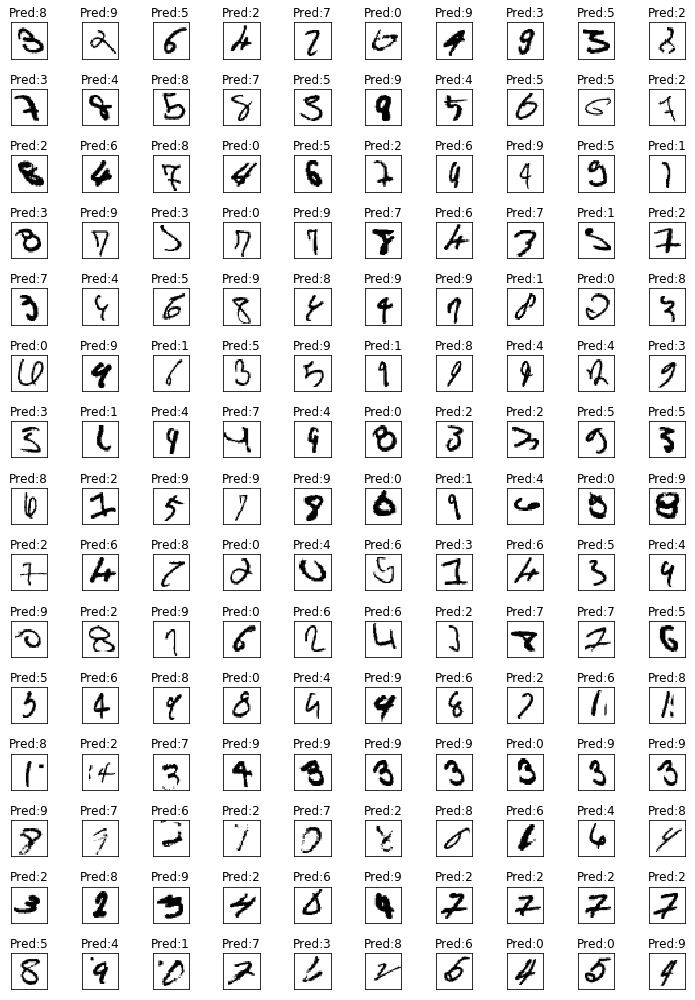

In [171]:
fig, axes = plt.subplots(15, 10, figsize=(10,14))

for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(X_test[errors][i].reshape(28, 28), cmap='gray_r')
    ax.set_title('Pred:' + str(y_test_pred[errors][i]))

fig.tight_layout()
plt.show()